In [1]:
import os 
import random 
from datetime import date
from tqdm import tqdm
from copy import deepcopy
import numpy as np 
import pandas as pd

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
from src.datasets.data import PAMAP2Reader
# from src.datasets.dataset import PAMAP2Dataset

from src.models.ts_transformer import RelativeGlobalAttention
from src.models.loss import FeatureLoss, AttributeLoss 
from src.utils.losses import SupConLoss

from src.utils.analysis import action_evaluator

In [3]:
# setup model configurations
config = {
    # general information
    "experiment-name": "test-001", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2", # "PAMAP2", "DaLiAc", "UTD"
    "Model": "RelativeGlobalAttention",
    "sem-space": 'attr',
    # model training configs
    "include_attribute_loss": True, 
    "semantic_size": 64,
    "n_actions": 18,
    "folding": True,
    "lr": 0.001,
    "n_epochs": 10,
    "optimizer": "adam",
    "batch_size": 32,
    "semantic_loss": "cosine_distance",
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    "feat_size": 128, # skel-AE hidden size and IMU-Anc output size
    # dataset configs
    "window_size": 5, 
    "overlap": 0.5,
    "seq_len": 200,
    "seen_split": 0.2,
    "unseen_split": 0.8
}

---

In [4]:
class Model6a(nn.Module):
    def __init__(self, in_ft, d_model, num_heads, ft_size, n_classes, max_len=1024, dropout=0.1):
        super(Model6a, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 
        self.n_classes = n_classes

        # feature prep layer
        self.DenseL = nn.Linear(in_ft, d_model)
        # relative global attention layer
        self.AttnL = RelativeGlobalAttention(self.d_model, self.num_heads, self.max_len)
        # positional encoding concat <-> 1DConv 
        self.Act = F.relu#_get_activation_fn(activation)
        self.AvgPoolL = nn.AvgPool2d((self.max_len,1))
        self.DenseL2 = nn.Linear(self.d_model, self.ft_size)
        self.dropout = nn.Dropout1d(dropout)
        self.logist = nn.Linear(self.ft_size, self.n_classes)

    def forward(self, x):
        out = self.DenseL(x)
        out = self.AttnL(out)
        out = self.Act(out)
        out = self.AvgPoolL(out)
        out = torch.squeeze(out)
        out = self.dropout(out)
        out1 = self.DenseL2(out)   
        out = self.logist(out1)     
        return out, out1

---

In [5]:
class LSTMEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(LSTMEncoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # define LSTM layer
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers)

    def forward(self, x_input):
        '''
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence; hidden gives the hidden state and cell state for the last element in the sequence                         
        '''
        lstm_out, self.hidden = self.lstm(x_input.view(x_input.shape[0], x_input.shape[1], self.input_size))
        return lstm_out, self.hidden     
    
    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))


class LSTMDecoder(nn.Module):    
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(LSTMDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        '''        
        : param x_input:                    should be 2D (batch_size, input_size)
        : param encoder_hidden_states:      hidden states
        : return output, hidden:            output gives all the hidden states in the sequence; hidden gives the hidden state and cell state for the last element in the sequence
        '''
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(0), encoder_hidden_states)
        output = self.linear(lstm_out.squeeze(0))     
        return output, self.hidden


class LSTMAE(nn.Module):
    def __init__(self, input_size, seq_len, hidden_size, batch_size, ae_type='recursive', teacher_forcing_ratio=0.5, device='cpu'):
        super(LSTMAE, self).__init__()
        self.input_size = input_size
        self.seq_len = seq_len
        self.hidden_size = hidden_size 
        self.bs = batch_size
        self.ae_type = ae_type # ['recursive', 'teacher_forcing', 'mixed_teacher_forcing']
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.device = device 

        self.encoder = LSTMEncoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = LSTMDecoder(input_size = input_size, hidden_size = hidden_size)

        self.encoder_hidden = self.encoder.init_hidden(self.bs)

    def forward(self, x):
        # encoding 
        encoder_output, self.encoder_hidden = self.encoder(x)
        # decoding 
        decoder_input = torch.rand((self.bs, self.input_size), requires_grad=True).to(self.device)#self.encoder_hidden[0].squeeze()
        # print(decoder_input.shape)
        decoder_hidden = self.encoder_hidden
        # outputs tensor
        outputs = torch.zeros(self.seq_len, self.bs, self.input_size).to(self.device)

        if self.ae_type == 'recursive':
            for t in range(self.seq_len):
                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                outputs[t] = decoder_output
                decoder_input = decoder_output
        
        elif self.ae_type == 'teacher_forcing':
            if random.random() < self.teacher_forcing_ratio:
                for t in range(self.seq_len):
                    decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                    outputs[t] = decoder_output
                    decoder_input = x[t, :, :]

            else:
                for t in range(self.seq_len):
                    decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                    outputs[t] = decoder_output
                    decoder_input = decoder_output

        elif self.ae_type == 'mixed_teacher_forcing':
            for t in range(self.seq_len):
                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                outputs[t] = decoder_output

                if random.random() < self.teacher_forcing_ratio:
                    decoder_input = x[t, :, :]
                else:
                    decoder_input = decoder_output

        return outputs, encoder_output[-1, ...]


In [6]:
ae_model = LSTMAE(input_size=36, seq_len=60, hidden_size=128, batch_size=32, ae_type='recursive')

---

In [7]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
# import PAMAP2 dataset
dt = config['dataset']
if dt == 'PAMAP2':
    dataReader = PAMAP2Reader('./data/PAMAP2_Dataset/Protocol/')

actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


g:\FYP\Codebases\Pose-AE\src\datasets\data.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [9]:
if dt == 'PAMAP2':
    fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

In [10]:
skeleton_data = np.load('./data/skeleton_movements.npz')
skeleton_classes, skeleton_mov = skeleton_data['arr_0'], skeleton_data['arr_1']

In [11]:
dataReader.label_map

[(1, 'lying'),
 (2, 'sitting'),
 (3, 'standing'),
 (4, 'walking'),
 (5, 'running'),
 (6, 'cycling'),
 (7, 'Nordic walking'),
 (9, 'watching TV'),
 (10, 'computer work'),
 (11, 'car driving'),
 (12, 'ascending stairs'),
 (13, 'descending stairs'),
 (16, 'vacuum cleaning'),
 (17, 'ironing'),
 (18, 'folding laundry'),
 (19, 'house cleaning'),
 (20, 'playing soccer'),
 (24, 'rope jumping')]

In [12]:
np.unique(skeleton_classes)

array(['Nordic walking', 'ascending stairs', 'car driving',
       'computer work', 'cycling', 'descending stairs', 'folding laundry',
       'house cleaning', 'ironing', 'lying', 'playing soccer',
       'rope jumping', 'running', 'sitting', 'standing',
       'vacuum cleaning', 'walking', 'watching TV'], dtype='<U17')

In [13]:
from collections import defaultdict

label2Id = {c[1]:i for i,c in enumerate(dataReader.label_map)}
action_dict = defaultdict(list)
skeleton_Ids = []
for i, a in enumerate(skeleton_classes):
    action_dict[label2Id[a]].append(i)
    skeleton_Ids.append(label2Id[a])

In [14]:
action_dict

defaultdict(list,
            {10: [0, 1, 2, 3, 4, 5],
             9: [6, 7, 8, 9],
             8: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
             5: [20, 21, 22, 23, 24],
             11: [25, 26, 27, 28, 29, 30],
             14: [31, 32, 33, 34, 35, 36, 37],
             15: [38, 39, 40, 41, 42, 43, 44],
             13: [45, 46, 47, 48, 49, 50],
             0: [51, 52],
             6: [53, 54, 55, 56, 57, 58, 59],
             16: [60, 61, 62, 63, 64],
             17: [65, 66],
             4: [67, 68, 69, 70, 71],
             1: [72, 73, 74, 75, 76, 77],
             2: [78, 79, 80, 81, 82],
             12: [83, 84, 85, 86, 87, 88],
             3: [89, 90, 91, 92],
             7: [93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104]})

---

In [15]:
class PAMAP2Dataset(Dataset):
    def __init__(self, data, actions, attributes, attribute_dict, action_classes, seq_len=120):
        super(PAMAP2Dataset, self).__init__()
        self.data = torch.from_numpy(data)
        self.actions = actions
        self.attribute_dict = attribute_dict
        self.seq_len = seq_len
        self.attributes = torch.from_numpy(attributes)
        self.action_classes = action_classes
        # build action to id mapping dict
        self.n_action = len(self.actions)
        self.action2Id = dict(zip(action_classes, range(self.n_action)))

    def __getitem__(self, ind):
        x = self.data[ind, ...]
        x_mask = np.array([0]) #self.padding_mask[ind, ...]
        target = self.actions[ind]
        y = torch.from_numpy(np.array([self.action2Id[target]]))
        # extraction semantic space generation skeleton sequences 
        skel_idx = random.choice(self.attribute_dict[target])
        y_feat = self.attributes[skel_idx, ...]
        return x, y, y_feat, x_mask

    def __len__(self):
        return self.data.shape[0]

    def getClassAttrs(self):
        sampling_idx = [random.choice(self.attribute_dict[i]) for i in self.action_classes]
        ft_mat = self.attributes[sampling_idx, ...]
        return ft_mat 

In [16]:
data_dict = dataReader.generate(unseen_classes=fold_cls_ids[0], seen_ratio=0.2, unseen_ratio=0.8, window_size=5.21, window_overlap=4.21, resample_freq=20)
sample_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=skeleton_mov, attribute_dict=action_dict, action_classes=data_dict['seen_classes'], seq_len=100)
sample_dl = DataLoader(sample_dt, batch_size=32, shuffle=True, pin_memory=True, drop_last=True)
for d in sample_dl:
    print(d[0].shape)
    break

torch.Size([32, 105, 51])


In [17]:
r = sample_dt.getClassAttrs()
r.shape

torch.Size([14, 60, 36])

In [18]:
pr = F.pad(input=r, pad=(0, 0, 0, 0, 0, 18), mode='constant', value=0)
pr.shape

torch.Size([32, 60, 36])

In [19]:
torch.transpose(r[1, ...], 1, 0).shape

torch.Size([36, 60])

In [20]:
r_out1, r_out2 = ae_model(torch.transpose(pr, 1, 0).float())
r_out1.shape, r_out2.shape

(torch.Size([60, 32, 36]), torch.Size([32, 128]))

---

In [21]:
class SkeletonDataset(Dataset):
    def __init__(self, movements, actions, action_dict):
        super(SkeletonDataset, self).__init__()
        self.movements = movements 
        self.actions = actions
        self.action_dict = deepcopy(dict(action_dict))
        self.actionsIDs = list(self.action_dict.keys())

    def __getitem__(self, idx):
        x1 = self.movements[idx, ...]
        action = self.actions[idx]

        partial_idx = random.sample(self.action_dict[action], k=1)[0]
        x2 = self.movements[partial_idx, ...]

        label = self.actionsIDs.index(action)
        # return np.transpose(x1, (1,0,2)), np.transpose(x2, (1,0,2)), label
        return x1, x2, label

    def __len__(self):
        return self.movements.shape[0]

    def getShape(self):
        return self.movements[0, ...].shape


In [22]:
action_dict

defaultdict(list,
            {10: [0, 1, 2, 3, 4, 5],
             9: [6, 7, 8, 9],
             8: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
             5: [20, 21, 22, 23, 24],
             11: [25, 26, 27, 28, 29, 30],
             14: [31, 32, 33, 34, 35, 36, 37],
             15: [38, 39, 40, 41, 42, 43, 44],
             13: [45, 46, 47, 48, 49, 50],
             0: [51, 52],
             6: [53, 54, 55, 56, 57, 58, 59],
             16: [60, 61, 62, 63, 64],
             17: [65, 66],
             4: [67, 68, 69, 70, 71],
             1: [72, 73, 74, 75, 76, 77],
             2: [78, 79, 80, 81, 82],
             12: [83, 84, 85, 86, 87, 88],
             3: [89, 90, 91, 92],
             7: [93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104]})

In [23]:
sample_dt = SkeletonDataset(skeleton_mov, skeleton_Ids, action_dict)
sample_dl = DataLoader(sample_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
for b in sample_dl:
    bx1, bx2, by = b 
    # bx = torch.transpose(bx1, 1, 0)
    bs, seq_len, ft_in = bx1.shape
    print(bx1.shape)
    break 

torch.Size([32, 60, 36])


In [24]:
sample_dt.getShape()

(60, 36)

---

In [25]:
def imu_train_step1(model , ae, dataloader, optimizer, loss_module, device, class_names, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()
    ae = ae.eval()

    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat, padding_masks = batch
            # print(X, targets, target_feat, target_attr)
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)
            padding_masks = padding_masks.to(device)  # 0s: ignore

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                class_output, feat_output = model(X)
            
            with torch.set_grad_enabled(False):
                _, target_feat = ae(torch.transpose(target_feat, 1, 0)) # batch second mode

            class_loss = loss_module['class'](class_output, targets.squeeze())
            feat_loss = loss_module['feature'](feat_output, target_feat)

            loss = loss_alpha*class_loss+(1-loss_alpha)*feat_loss

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class
            # using cosine 
            pred_class = np.argmax(class_output.cpu().detach().numpy(), axis=1)
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)
            
    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [26]:
def ae_train_step1(model , dataloader, optimizer, loss_module, device, batch_size, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()
    model.to(device)

    epoch_loss = 0 
    total_samples = 0 

    with tqdm(dataloader, unit='batch', desc=phase) as tepoch:
        for batch in tepoch:
            x1, x2, labels = batch 
            # post-process 
            xa = torch.transpose(torch.vstack([x1, x2]), 1, 0)
            # device offload 
            xa = xa.float().to(device)
            labels = labels.float()

            # set optimizer grad to zero 
            optimizer.zero_grad()
            # get model prediction 
            with torch.set_grad_enabled(phase=='train'):
                skel_output, ft_output = model(xa)

            # reconstruct the output 
            f1, f2 = torch.split(ft_output, [batch_size//2, batch_size//2], dim=0)
            cons_output = torch.stack([f1.squeeze(1), f2.squeeze(1)], dim=1)
            # calc. contrastive loss 
            con_loss = loss_module['contrast'](cons_output, labels)
            # calc. reconstruction loss 
            l2_loss = loss_module['recons'](xa, skel_output)
            # calc. total loss
            total_loss = loss_alpha*con_loss + (1-loss_alpha)*l2_loss

            if phase == 'train':
                total_loss.backward()
                optimizer.step()

            metrics = {'contrastive loss ': con_loss.item(), 'reconstruction loss': l2_loss.item()}
            with torch.no_grad():
                    total_samples += len(labels)
                    epoch_loss += total_loss.item()
            
            tepoch.set_postfix(metrics)

    epoch_loss = epoch_loss/total_samples
    return metrics

In [27]:
def eval_step1(model, ae, dataloader, loss_module, device, class_names, target_feat_met, phase='seen', l2_reg=False, print_report=True, loss_alpha=0.7, batch_size=32):
    model = model.train()
    ae = ae.eval()

    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}

    # generate unseen action_semantic from unseen skeleton seq. 
    ns, _, _ = target_feat_met.shape 
    padded_mat = F.pad(input=target_feat_met, pad=(0,0,0,0,0,batch_size-ns), mode='constant', value=0)
    _, vector_out = ae(torch.transpose(padded_mat, 1, 0).float().to(device)) # batch second mode
    action_feat_mat = vector_out[:ns, :].cpu().detach().numpy() # batch second mode

    print("target feat mat", target_feat_met.shape, "action feat mat", action_feat_mat.shape)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat, padding_masks = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)
            padding_masks = padding_masks.to(device)  # 0s: ignore
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                class_output, feat_output = model(X)

            with torch.set_grad_enabled(False):
                _, target_feat = ae(torch.transpose(target_feat, 1, 0)) # batch second mode
                
            class_loss = loss_module['class'](class_output, targets.squeeze())
            feat_loss = loss_module['feature'](feat_output, target_feat)

            loss = loss_alpha*class_loss+(1-loss_alpha)*feat_loss

            # convert feature vector into action class
            # using cosine 
            if phase == 'seen':
                pred_action = np.argmax(class_output.cpu().detach().numpy(), axis=1)
            else:
                # print("feat output", feat_output.shape)
                feat_numpy = torch.sigmoid(feat_output.cpu().detach())
                action_probs = cosine_similarity(feat_numpy, action_feat_mat)
                pred_action = np.argmax(action_probs, axis=1)
                
            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action)
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})
    
    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report)
    return metrics_dict

---

================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']
Initiate IMU datasets ...
Initiate Skeleton dataset ... 
Initial Models ...
Start Models training ...


train: 100%|██████████| 523/523 [00:27<00:00, 18.79batch/s, loss=0.314, accuracy=0.875]


target feat mat torch.Size([14, 60, 36]) action feat mat (14, 128)


seen: 100%|██████████| 130/130 [00:05<00:00, 24.97batch/s, loss=0.237]


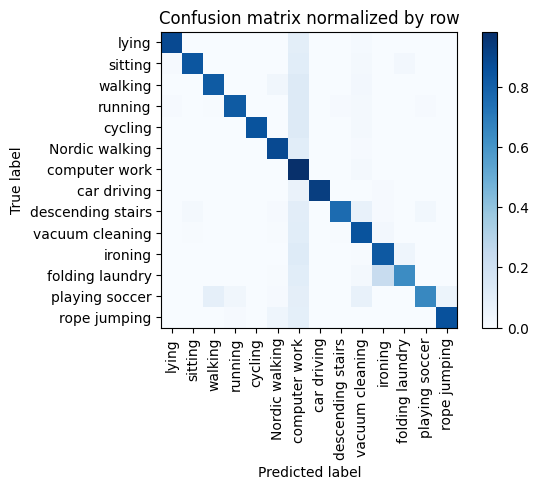

Training Epoch:  10%|█         | 1/10 [00:34<05:12, 34.72s/it]

Overall accuracy: 0.850



train: 100%|██████████| 523/523 [00:27<00:00, 19.03batch/s, loss=0.54, accuracy=0.781]


target feat mat torch.Size([14, 60, 36]) action feat mat (14, 128)


seen: 100%|██████████| 130/130 [00:05<00:00, 23.33batch/s, loss=0.644]


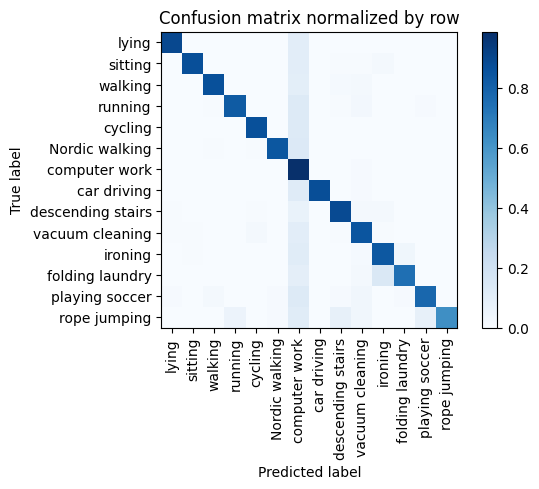

Training Epoch:  20%|██        | 2/10 [01:08<04:34, 34.27s/it]

Overall accuracy: 0.866



train: 100%|██████████| 523/523 [00:27<00:00, 19.03batch/s, loss=0.188, accuracy=0.906]


target feat mat torch.Size([14, 60, 36]) action feat mat (14, 128)


seen: 100%|██████████| 130/130 [00:05<00:00, 24.49batch/s, loss=0.208]


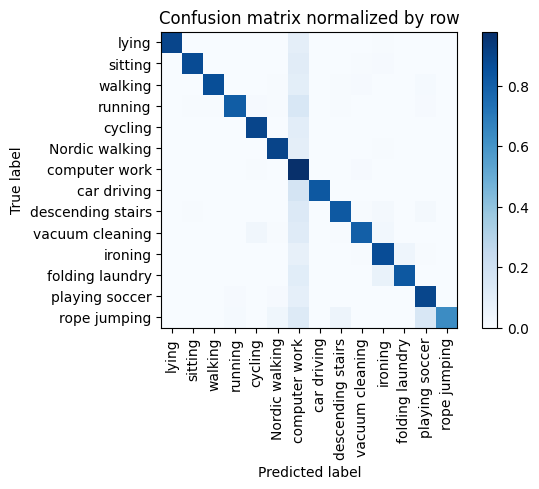

Training Epoch:  30%|███       | 3/10 [01:42<03:57, 33.98s/it]

Overall accuracy: 0.875



train: 100%|██████████| 523/523 [00:26<00:00, 19.74batch/s, loss=0.395, accuracy=0.844]


target feat mat torch.Size([14, 60, 36]) action feat mat (14, 128)


seen: 100%|██████████| 130/130 [00:05<00:00, 24.11batch/s, loss=0.246]


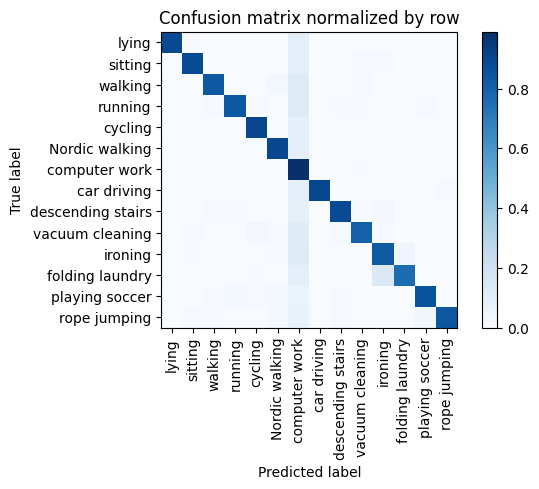

Training Epoch:  40%|████      | 4/10 [02:15<03:20, 33.49s/it]

Overall accuracy: 0.875



train: 100%|██████████| 523/523 [00:22<00:00, 23.48batch/s, loss=0.277, accuracy=0.875]


target feat mat torch.Size([14, 60, 36]) action feat mat (14, 128)


seen: 100%|██████████| 130/130 [00:04<00:00, 27.05batch/s, loss=0.122]


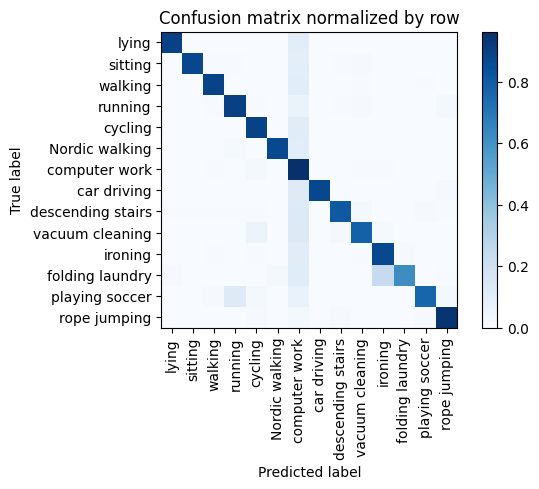

Training Epoch:  50%|█████     | 5/10 [02:42<02:37, 31.49s/it]

Overall accuracy: 0.869



train: 100%|██████████| 523/523 [00:21<00:00, 24.41batch/s, loss=0.171, accuracy=0.906]


target feat mat torch.Size([14, 60, 36]) action feat mat (14, 128)


seen: 100%|██████████| 130/130 [00:04<00:00, 27.35batch/s, loss=0.732]


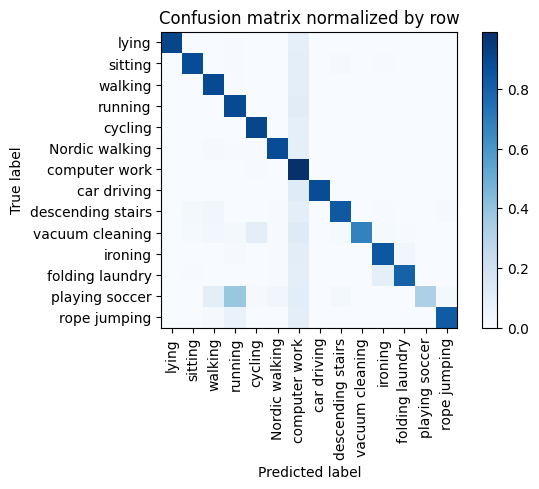

Training Epoch:  60%|██████    | 6/10 [03:10<02:00, 30.02s/it]

Overall accuracy: 0.862



train: 100%|██████████| 523/523 [00:21<00:00, 24.17batch/s, loss=0.2, accuracy=0.875]


target feat mat torch.Size([14, 60, 36]) action feat mat (14, 128)


seen: 100%|██████████| 130/130 [00:04<00:00, 27.17batch/s, loss=-.0175]


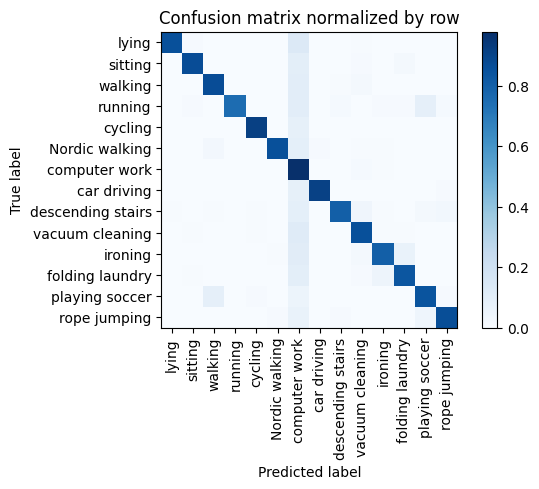

Training Epoch:  70%|███████   | 7/10 [03:37<01:27, 29.12s/it]

Overall accuracy: 0.868



train: 100%|██████████| 523/523 [00:21<00:00, 24.08batch/s, loss=0.0743, accuracy=0.906]


target feat mat torch.Size([14, 60, 36]) action feat mat (14, 128)


seen: 100%|██████████| 130/130 [00:04<00:00, 26.58batch/s, loss=0.121]


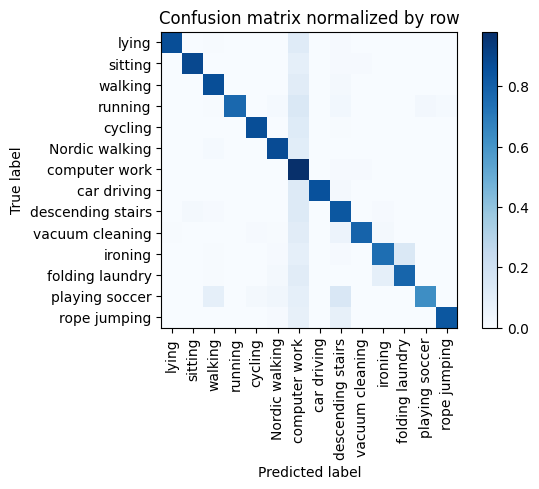

Training Epoch:  80%|████████  | 8/10 [04:04<00:57, 28.58s/it]

Overall accuracy: 0.849



train: 100%|██████████| 523/523 [00:21<00:00, 24.20batch/s, loss=0.384, accuracy=0.781]


target feat mat torch.Size([14, 60, 36]) action feat mat (14, 128)


seen: 100%|██████████| 130/130 [00:04<00:00, 27.92batch/s, loss=0.0407]


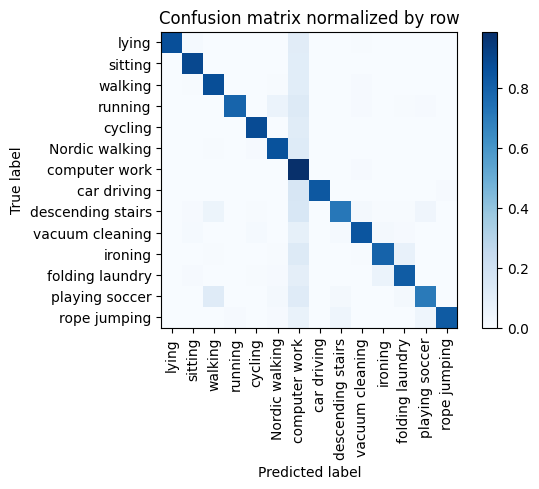

Training Epoch:  90%|█████████ | 9/10 [04:31<00:28, 28.13s/it]

Overall accuracy: 0.859



train: 100%|██████████| 523/523 [00:21<00:00, 23.83batch/s, loss=0.199, accuracy=0.875]


target feat mat torch.Size([14, 60, 36]) action feat mat (14, 128)


seen: 100%|██████████| 130/130 [00:05<00:00, 24.92batch/s, loss=0.36]


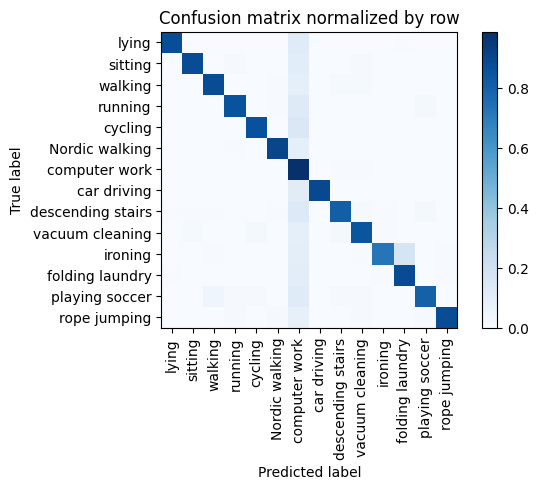

Overall accuracy: 0.867

target feat mat torch.Size([4, 60, 36]) action feat mat (4, 128)


unseen: 100%|██████████| 175/175 [00:06<00:00, 27.83batch/s, loss=12.4]


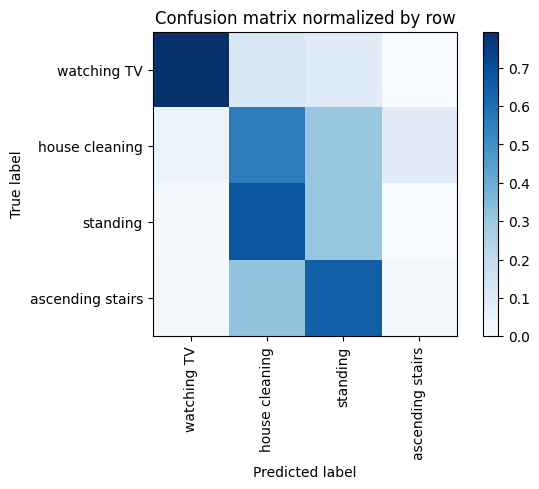

Overall accuracy: 0.408

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        standing       0.300      0.311      0.306      0.331       1852|	 house cleaning: 0.677,	watching TV: 0.012,	
  house cleaning       0.379      0.561      0.452      0.328       1839|	 standing: 0.306,	ascending stairs: 0.089,	
ascending stairs       0.103      0.018      0.030      0.193       1080|	 standing: 0.650,	house cleaning: 0.319,	
     watching TV       0.850      0.794      0.821      0.148        829|	 house cleaning: 0.115,	standing: 0.092,	

----------------------------------------------------------------------------------------------------
     avg / total       0.370      0.408      0.377        1.0       5600|	      

{'total_accuracy': 0.4080357142857143, 'precision': 0.408143787107494, 'recall': 0.4208774112895331, 'f1': 0.4022275594805299}
================ Fold-1 ================
Unseen Classes : ['walking', 'rope jumping', 'sitting', 'desce

train: 100%|██████████| 524/524 [00:23<00:00, 22.74batch/s, loss=0.461, accuracy=0.844]


target feat mat torch.Size([14, 60, 36]) action feat mat (14, 128)


seen: 100%|██████████| 131/131 [00:04<00:00, 27.52batch/s, loss=0.41]


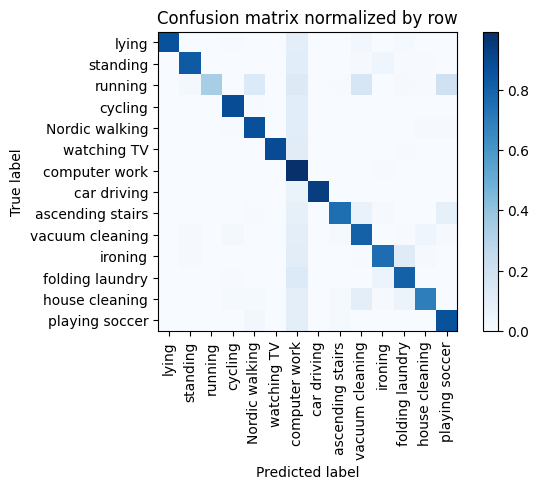

Training Epoch:  10%|█         | 1/10 [00:28<04:18, 28.73s/it]

Overall accuracy: 0.821



train: 100%|██████████| 524/524 [00:22<00:00, 23.77batch/s, loss=0.0862, accuracy=1]


target feat mat torch.Size([14, 60, 36]) action feat mat (14, 128)


seen: 100%|██████████| 131/131 [00:04<00:00, 27.72batch/s, loss=0.118]


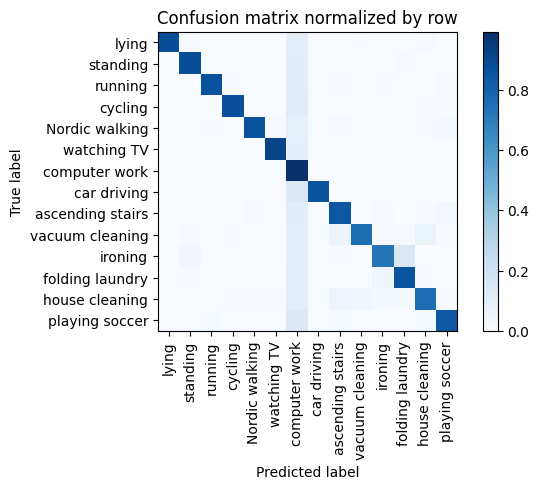

Training Epoch:  20%|██        | 2/10 [00:56<03:44, 28.08s/it]

Overall accuracy: 0.852



train: 100%|██████████| 524/524 [00:21<00:00, 24.26batch/s, loss=0.538, accuracy=0.875]


target feat mat torch.Size([14, 60, 36]) action feat mat (14, 128)


seen: 100%|██████████| 131/131 [00:04<00:00, 28.03batch/s, loss=0.256]


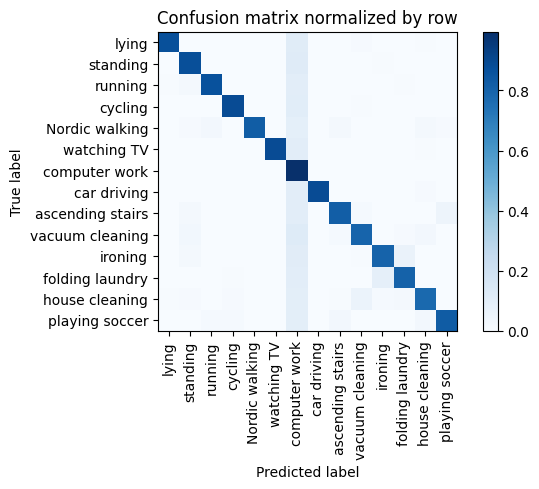

Training Epoch:  30%|███       | 3/10 [01:23<03:13, 27.68s/it]

Overall accuracy: 0.858



train: 100%|██████████| 524/524 [00:21<00:00, 24.81batch/s, loss=0.573, accuracy=0.812]


target feat mat torch.Size([14, 60, 36]) action feat mat (14, 128)


seen: 100%|██████████| 131/131 [00:04<00:00, 27.85batch/s, loss=0.187]


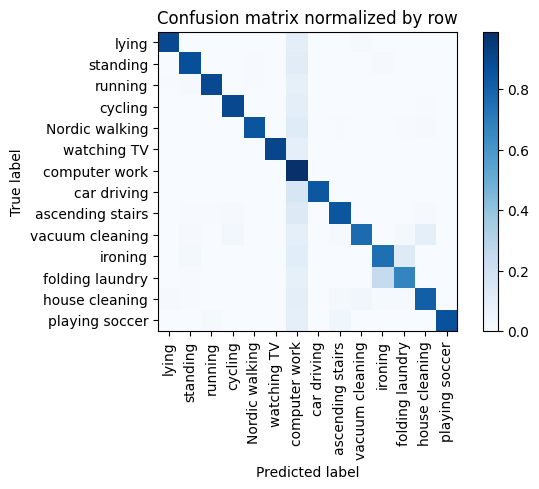

Training Epoch:  40%|████      | 4/10 [01:50<02:43, 27.29s/it]

Overall accuracy: 0.853



train: 100%|██████████| 524/524 [00:21<00:00, 24.50batch/s, loss=0.225, accuracy=0.875]


target feat mat torch.Size([14, 60, 36]) action feat mat (14, 128)


seen: 100%|██████████| 131/131 [00:04<00:00, 27.28batch/s, loss=0.166]


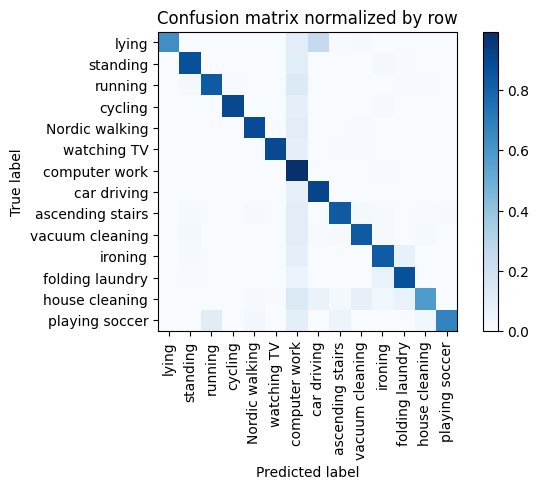

Training Epoch:  50%|█████     | 5/10 [02:17<02:15, 27.19s/it]

Overall accuracy: 0.831



train: 100%|██████████| 524/524 [00:21<00:00, 24.36batch/s, loss=0.269, accuracy=0.844]


target feat mat torch.Size([14, 60, 36]) action feat mat (14, 128)


seen: 100%|██████████| 131/131 [00:04<00:00, 27.61batch/s, loss=0.213]


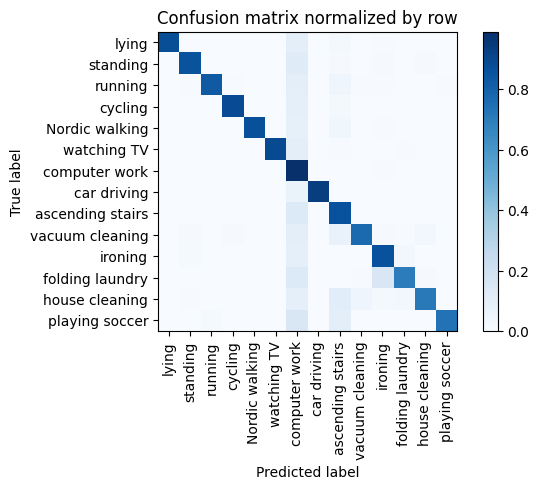

Training Epoch:  60%|██████    | 6/10 [02:44<01:48, 27.17s/it]

Overall accuracy: 0.855



train: 100%|██████████| 524/524 [00:21<00:00, 24.48batch/s, loss=0.262, accuracy=0.875]


target feat mat torch.Size([14, 60, 36]) action feat mat (14, 128)


seen: 100%|██████████| 131/131 [00:04<00:00, 27.38batch/s, loss=0.252]


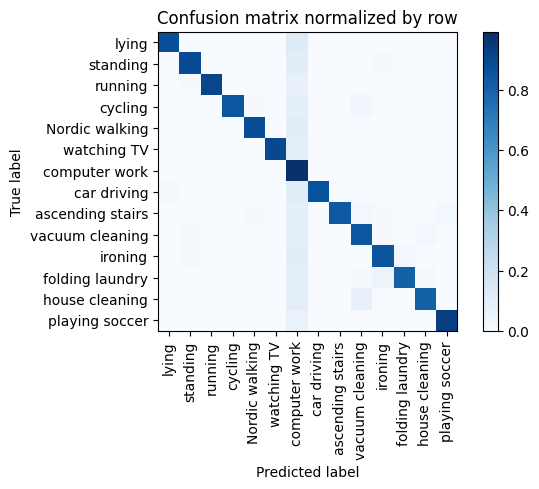

Training Epoch:  70%|███████   | 7/10 [03:11<01:21, 27.12s/it]

Overall accuracy: 0.878



train: 100%|██████████| 524/524 [00:21<00:00, 24.36batch/s, loss=0.165, accuracy=0.906]


target feat mat torch.Size([14, 60, 36]) action feat mat (14, 128)


seen: 100%|██████████| 131/131 [00:04<00:00, 27.40batch/s, loss=0.0189]


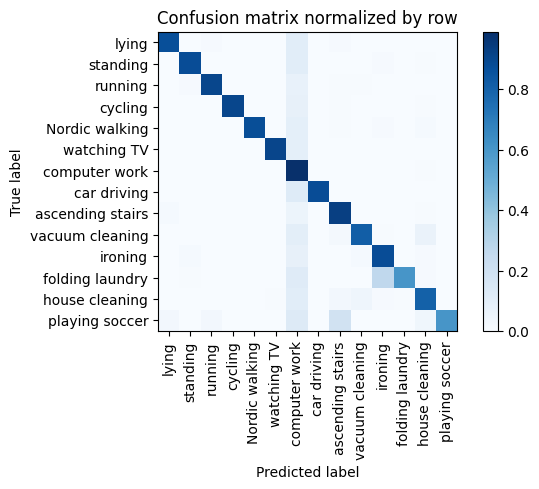

Training Epoch:  80%|████████  | 8/10 [03:38<00:54, 27.13s/it]

Overall accuracy: 0.871



train: 100%|██████████| 524/524 [00:21<00:00, 24.42batch/s, loss=0.62, accuracy=0.75]


target feat mat torch.Size([14, 60, 36]) action feat mat (14, 128)


seen: 100%|██████████| 131/131 [00:04<00:00, 27.88batch/s, loss=0.175]


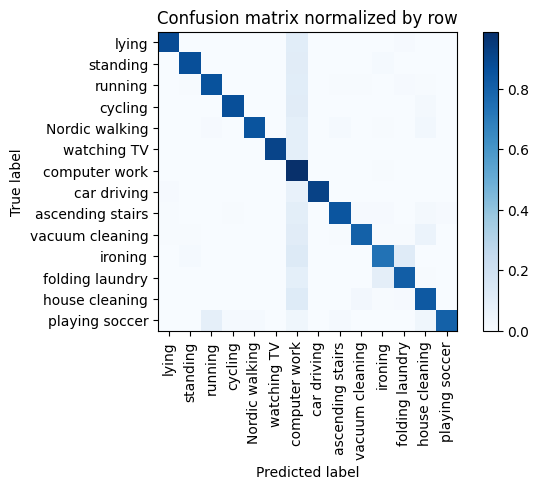

Training Epoch:  90%|█████████ | 9/10 [04:05<00:27, 27.19s/it]

Overall accuracy: 0.859



train: 100%|██████████| 524/524 [00:21<00:00, 24.49batch/s, loss=0.457, accuracy=0.781]


target feat mat torch.Size([14, 60, 36]) action feat mat (14, 128)


seen: 100%|██████████| 131/131 [00:04<00:00, 27.43batch/s, loss=0.082]


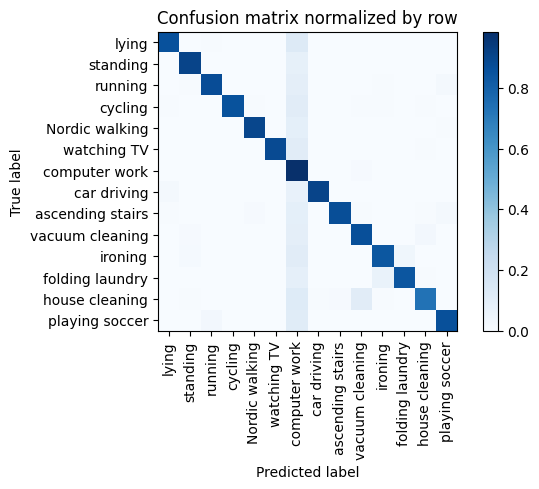

Overall accuracy: 0.875

target feat mat torch.Size([4, 60, 36]) action feat mat (4, 128)


unseen: 100%|██████████| 173/173 [00:06<00:00, 28.57batch/s, loss=30.8]


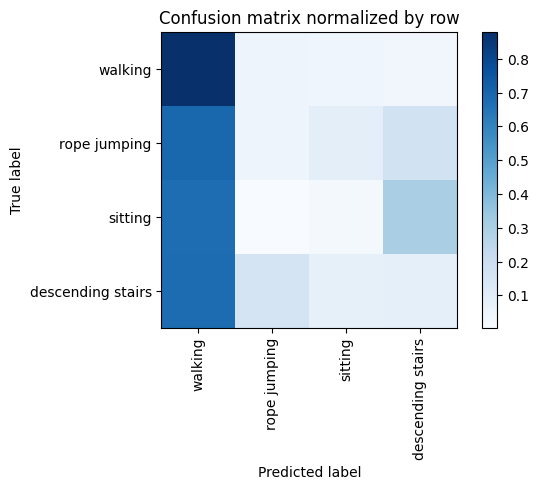

Overall accuracy: 0.397

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.486      0.880      0.627      0.422       2334|	 rope jumping: 0.046,	sitting: 0.042,	
          sitting       0.158      0.022      0.039      0.325       1797|	 walking: 0.673,	descending stairs: 0.300,	
descending stairs       0.105      0.086      0.094      0.171        947|	 walking: 0.677,	rope jumping: 0.159,	
     rope jumping       0.076      0.048      0.059      0.083        458|	 walking: 0.692,	descending stairs: 0.170,	sitting: 0.090,	

----------------------------------------------------------------------------------------------------
      avg / total       0.281      0.397      0.298        1.0       5536|	      

{'total_accuracy': 0.39685693641618497, 'precision': 0.2064443727621404, 'recall': 0.2589654486113187, 'f1': 0.20469831408315706}
================ Fold-2 ================
Unseen Classes : ['playing soccer', 'lying',

train: 100%|██████████| 485/485 [00:19<00:00, 24.29batch/s, loss=0.219, accuracy=0.875]


target feat mat torch.Size([14, 60, 36]) action feat mat (14, 128)


seen: 100%|██████████| 121/121 [00:04<00:00, 27.23batch/s, loss=0.766]


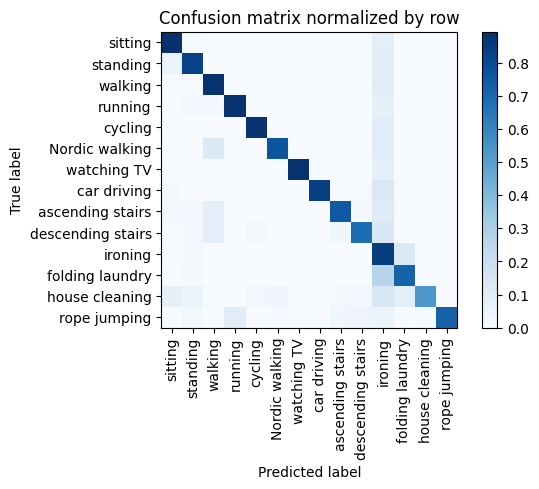

Training Epoch:  10%|█         | 1/10 [00:25<03:48, 25.42s/it]

Overall accuracy: 0.800



train: 100%|██████████| 485/485 [00:20<00:00, 24.12batch/s, loss=0.351, accuracy=0.844]


target feat mat torch.Size([14, 60, 36]) action feat mat (14, 128)


seen: 100%|██████████| 121/121 [00:04<00:00, 26.86batch/s, loss=0.365]


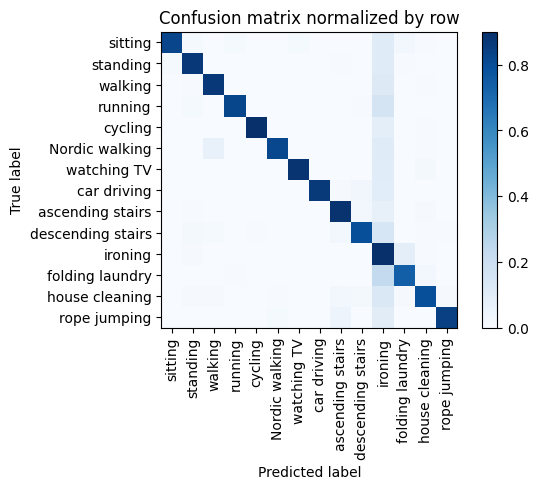

Training Epoch:  20%|██        | 2/10 [00:50<03:23, 25.43s/it]

Overall accuracy: 0.848



train: 100%|██████████| 485/485 [00:19<00:00, 24.33batch/s, loss=0.486, accuracy=0.781]


target feat mat torch.Size([14, 60, 36]) action feat mat (14, 128)


seen: 100%|██████████| 121/121 [00:04<00:00, 27.44batch/s, loss=0.42]


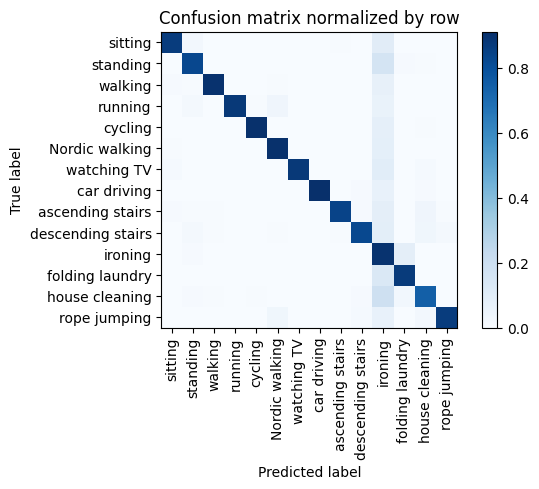

Training Epoch:  30%|███       | 3/10 [01:16<02:57, 25.34s/it]

Overall accuracy: 0.866



train: 100%|██████████| 485/485 [00:19<00:00, 24.53batch/s, loss=0.402, accuracy=0.844]


target feat mat torch.Size([14, 60, 36]) action feat mat (14, 128)


seen: 100%|██████████| 121/121 [00:04<00:00, 27.23batch/s, loss=0.348]


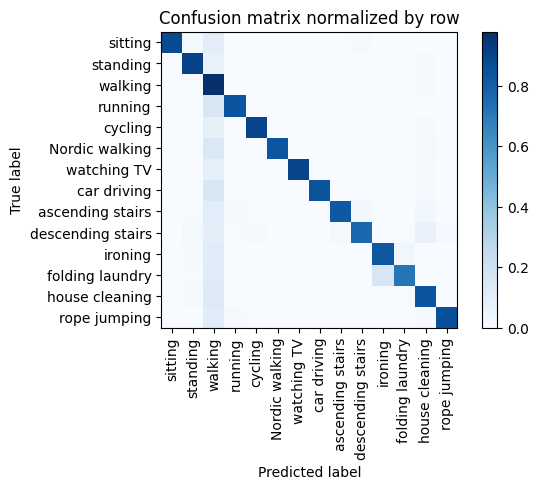

Training Epoch:  40%|████      | 4/10 [01:41<02:31, 25.24s/it]

Overall accuracy: 0.862



train: 100%|██████████| 485/485 [00:20<00:00, 24.11batch/s, loss=0.178, accuracy=0.906]


target feat mat torch.Size([14, 60, 36]) action feat mat (14, 128)


seen: 100%|██████████| 121/121 [00:04<00:00, 26.38batch/s, loss=0.372]


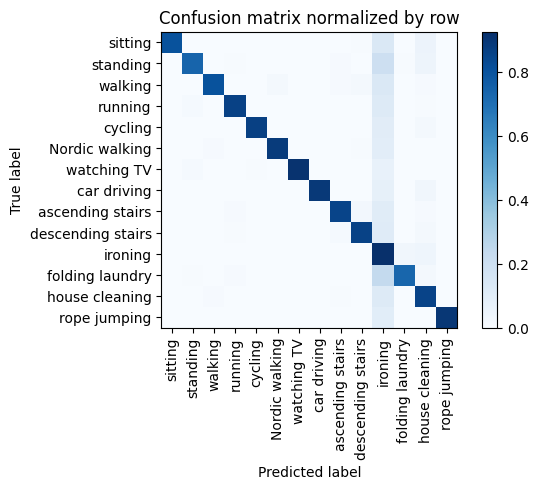

Training Epoch:  50%|█████     | 5/10 [02:06<02:06, 25.35s/it]

Overall accuracy: 0.845



train: 100%|██████████| 485/485 [00:19<00:00, 24.37batch/s, loss=0.258, accuracy=0.875]


target feat mat torch.Size([14, 60, 36]) action feat mat (14, 128)


seen: 100%|██████████| 121/121 [00:04<00:00, 27.59batch/s, loss=0.181]


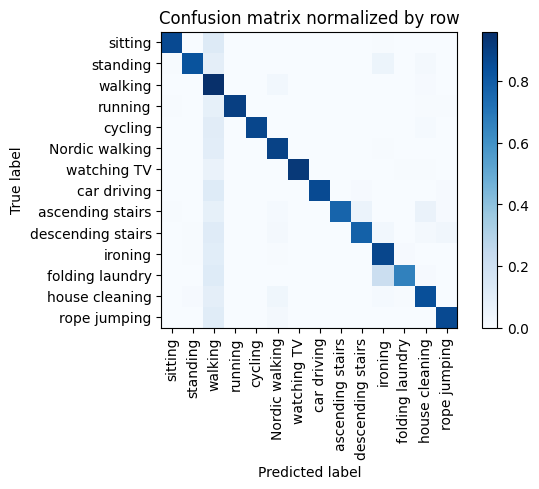

Training Epoch:  60%|██████    | 6/10 [02:31<01:41, 25.29s/it]

Overall accuracy: 0.861



train: 100%|██████████| 485/485 [00:20<00:00, 24.16batch/s, loss=0.541, accuracy=0.812]


target feat mat torch.Size([14, 60, 36]) action feat mat (14, 128)


seen: 100%|██████████| 121/121 [00:04<00:00, 27.28batch/s, loss=0.0429]


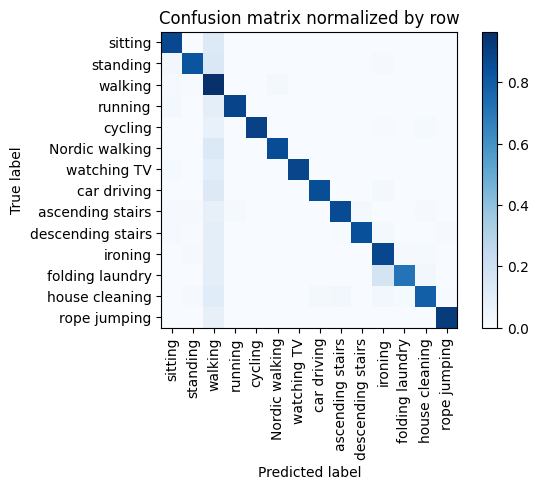

Training Epoch:  70%|███████   | 7/10 [02:57<01:15, 25.31s/it]

Overall accuracy: 0.864



train: 100%|██████████| 485/485 [00:20<00:00, 24.20batch/s, loss=0.237, accuracy=0.875]


target feat mat torch.Size([14, 60, 36]) action feat mat (14, 128)


seen: 100%|██████████| 121/121 [00:04<00:00, 27.22batch/s, loss=0.206]


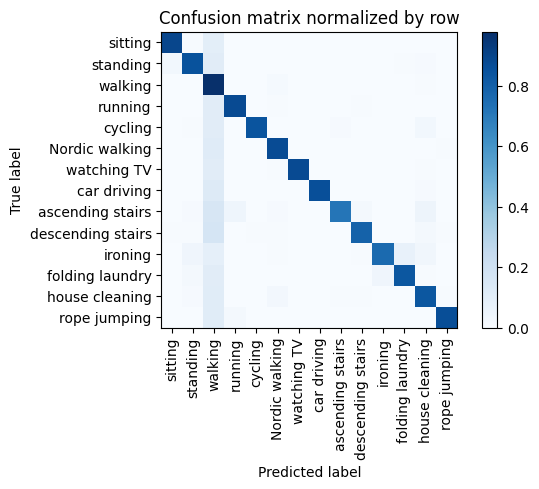

Training Epoch:  80%|████████  | 8/10 [03:22<00:50, 25.32s/it]

Overall accuracy: 0.850



train: 100%|██████████| 485/485 [00:19<00:00, 24.31batch/s, loss=0.0147, accuracy=1]


target feat mat torch.Size([14, 60, 36]) action feat mat (14, 128)


seen: 100%|██████████| 121/121 [00:04<00:00, 27.51batch/s, loss=0.373]


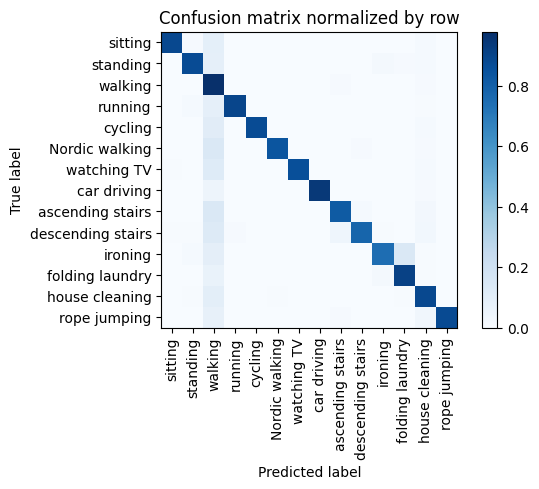

Training Epoch:  90%|█████████ | 9/10 [03:47<00:25, 25.29s/it]

Overall accuracy: 0.866



train: 100%|██████████| 485/485 [00:19<00:00, 24.40batch/s, loss=0.192, accuracy=0.875]


target feat mat torch.Size([14, 60, 36]) action feat mat (14, 128)


seen: 100%|██████████| 121/121 [00:04<00:00, 27.35batch/s, loss=0.209]


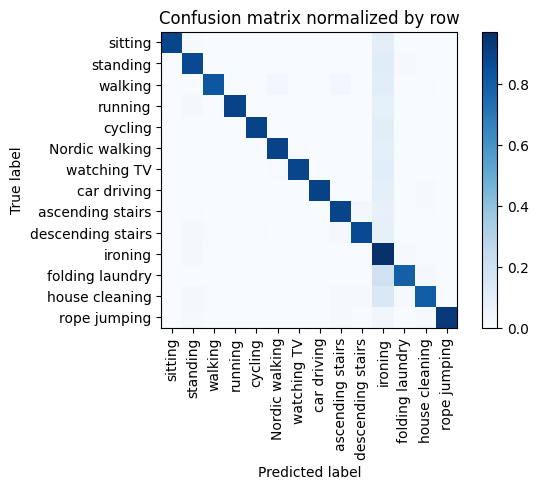

Overall accuracy: 0.878

target feat mat torch.Size([4, 60, 36]) action feat mat (4, 128)


unseen: 100%|██████████| 222/222 [00:07<00:00, 29.19batch/s, loss=24.4]


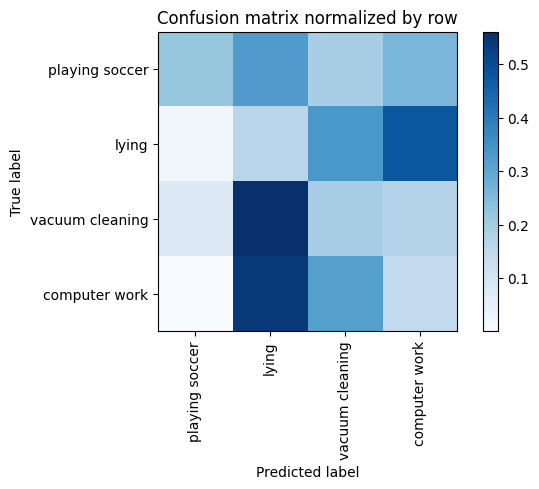

Overall accuracy: 0.167

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.252      0.144      0.183      0.431       3065|	 lying: 0.537,	vacuum cleaning: 0.318,	
          lying       0.100      0.164      0.124      0.264       1877|	 computer work: 0.478,	vacuum cleaning: 0.338,	
vacuum cleaning       0.166      0.198      0.180      0.240       1704|	 lying: 0.560,	computer work: 0.168,	
 playing soccer       0.374      0.221      0.277      0.064        458|	 lying: 0.325,	computer work: 0.260,	

----------------------------------------------------------------------------------------------------
    avg / total       0.199      0.167      0.173        1.0       7104|	      

{'total_accuracy': 0.16680743243243243, 'precision': 0.22315525870390418, 'recall': 0.1813522804110651, 'f1': 0.19131344573151246}
================ Fold-3 ================
Unseen Classes : ['cycling', 'running', 'Nordic walking']
Initiate IMU da

train: 100%|██████████| 553/553 [00:22<00:00, 24.30batch/s, loss=0.808, accuracy=0.656]


target feat mat torch.Size([15, 60, 36]) action feat mat (15, 128)


seen: 100%|██████████| 138/138 [00:05<00:00, 27.24batch/s, loss=0.229]


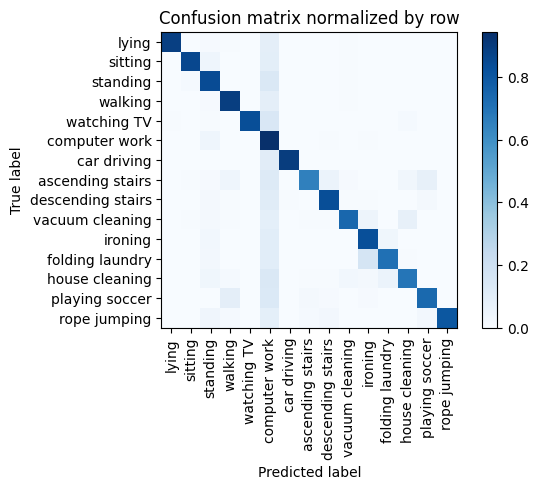

Training Epoch:  10%|█         | 1/10 [00:28<04:19, 28.85s/it]

Overall accuracy: 0.830



train: 100%|██████████| 553/553 [00:22<00:00, 24.29batch/s, loss=0.374, accuracy=0.844]


target feat mat torch.Size([15, 60, 36]) action feat mat (15, 128)


seen: 100%|██████████| 138/138 [00:05<00:00, 27.59batch/s, loss=0.483]


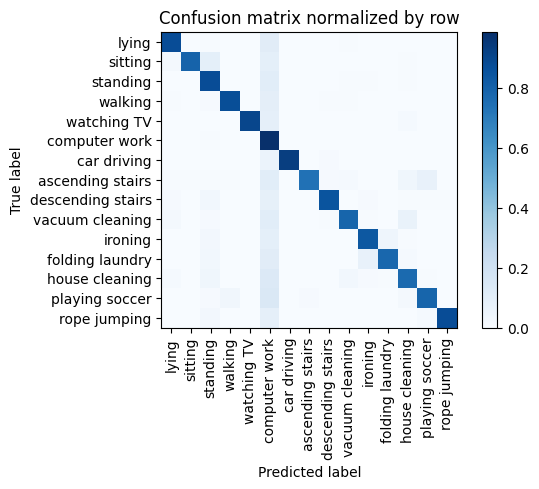

Training Epoch:  20%|██        | 2/10 [00:57<03:50, 28.82s/it]

Overall accuracy: 0.854



train: 100%|██████████| 553/553 [00:22<00:00, 24.14batch/s, loss=0.282, accuracy=0.938]


target feat mat torch.Size([15, 60, 36]) action feat mat (15, 128)


seen: 100%|██████████| 138/138 [00:05<00:00, 26.96batch/s, loss=0.293]


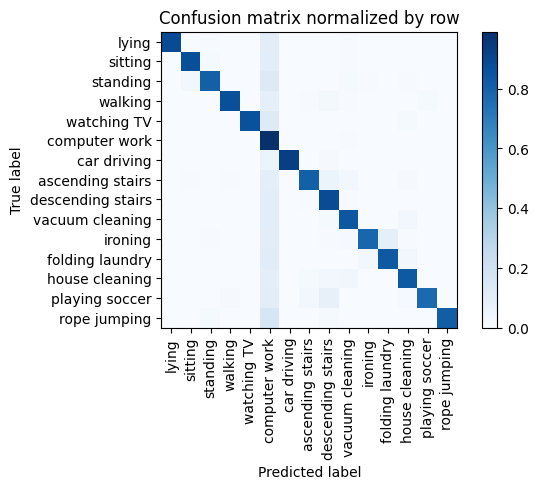

Training Epoch:  30%|███       | 3/10 [01:26<03:21, 28.86s/it]

Overall accuracy: 0.863



train: 100%|██████████| 553/553 [00:23<00:00, 23.72batch/s, loss=0.054, accuracy=1]


target feat mat torch.Size([15, 60, 36]) action feat mat (15, 128)


seen: 100%|██████████| 138/138 [00:05<00:00, 27.00batch/s, loss=0.352]


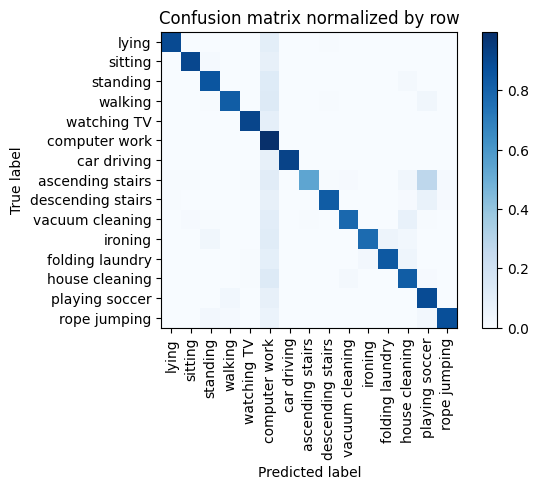

Training Epoch:  40%|████      | 4/10 [01:55<02:54, 29.03s/it]

Overall accuracy: 0.851



train: 100%|██████████| 553/553 [00:22<00:00, 24.15batch/s, loss=0.421, accuracy=0.906]


target feat mat torch.Size([15, 60, 36]) action feat mat (15, 128)


seen: 100%|██████████| 138/138 [00:05<00:00, 27.50batch/s, loss=0.33]


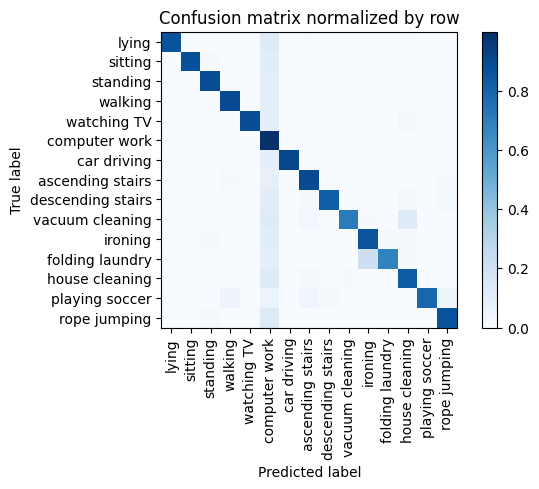

Training Epoch:  50%|█████     | 5/10 [02:24<02:24, 28.96s/it]

Overall accuracy: 0.868



train: 100%|██████████| 553/553 [00:23<00:00, 23.96batch/s, loss=0.284, accuracy=0.844]


target feat mat torch.Size([15, 60, 36]) action feat mat (15, 128)


seen: 100%|██████████| 138/138 [00:05<00:00, 26.79batch/s, loss=0.284]


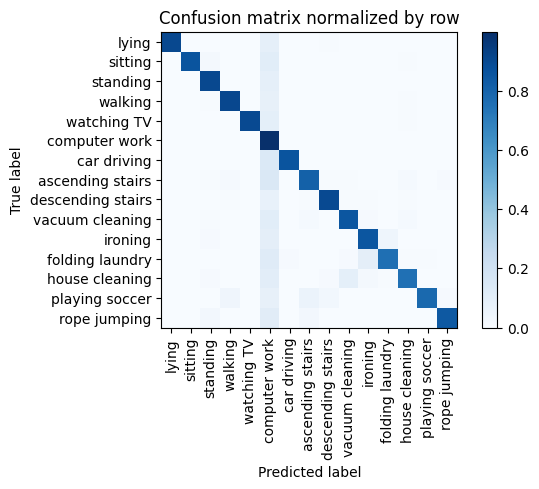

Training Epoch:  60%|██████    | 6/10 [02:53<01:55, 28.99s/it]

Overall accuracy: 0.877



train: 100%|██████████| 553/553 [00:23<00:00, 23.93batch/s, loss=-.0226, accuracy=1]


target feat mat torch.Size([15, 60, 36]) action feat mat (15, 128)


seen: 100%|██████████| 138/138 [00:05<00:00, 26.96batch/s, loss=0.502]


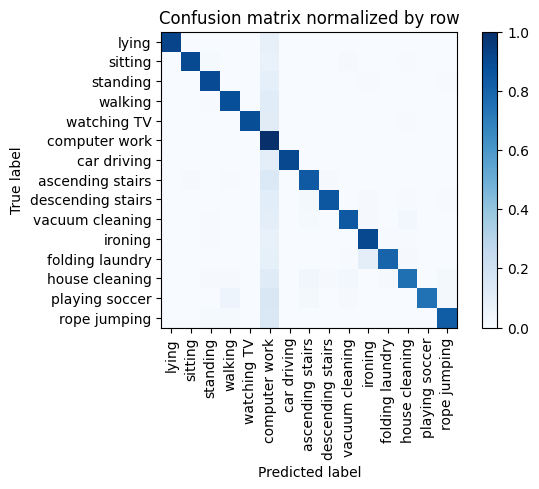

Training Epoch:  70%|███████   | 7/10 [03:23<01:27, 29.17s/it]

Overall accuracy: 0.883



train: 100%|██████████| 553/553 [00:22<00:00, 24.22batch/s, loss=0.158, accuracy=0.906]


target feat mat torch.Size([15, 60, 36]) action feat mat (15, 128)


seen: 100%|██████████| 138/138 [00:05<00:00, 26.33batch/s, loss=0.285]


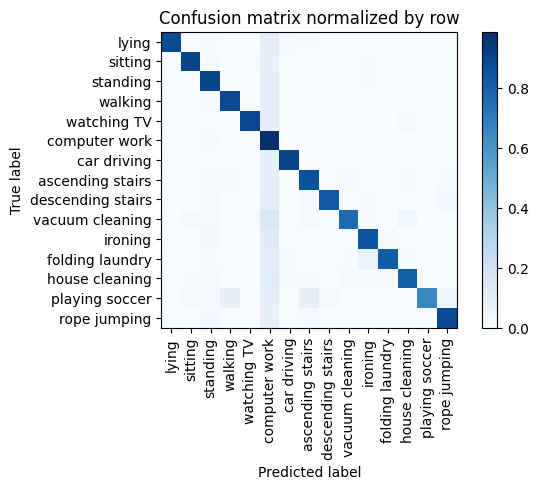

Training Epoch:  80%|████████  | 8/10 [03:52<00:58, 29.10s/it]

Overall accuracy: 0.872



train: 100%|██████████| 553/553 [00:22<00:00, 24.59batch/s, loss=0.195, accuracy=0.844]


target feat mat torch.Size([15, 60, 36]) action feat mat (15, 128)


seen: 100%|██████████| 138/138 [00:05<00:00, 27.57batch/s, loss=0.288]


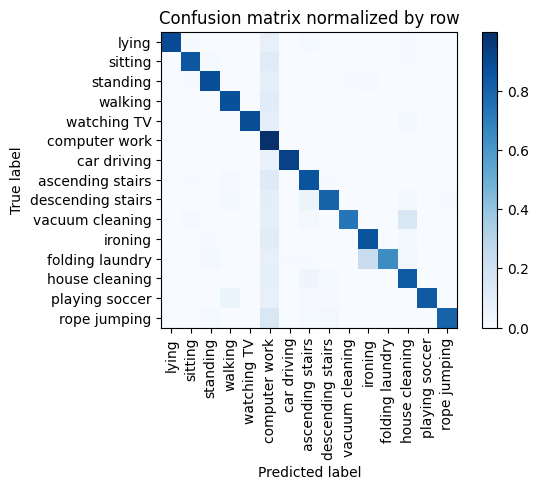

Training Epoch:  90%|█████████ | 9/10 [04:20<00:28, 28.86s/it]

Overall accuracy: 0.863



train: 100%|██████████| 553/553 [00:23<00:00, 23.93batch/s, loss=0.312, accuracy=0.812]


target feat mat torch.Size([15, 60, 36]) action feat mat (15, 128)


seen: 100%|██████████| 138/138 [00:05<00:00, 26.87batch/s, loss=0.0869]


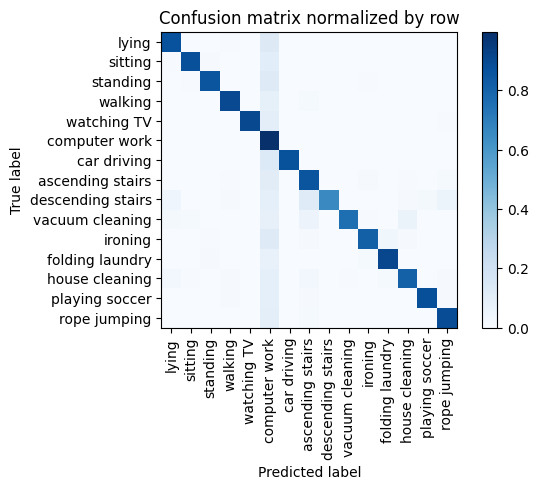

Overall accuracy: 0.865

target feat mat torch.Size([3, 60, 36]) action feat mat (3, 128)


unseen: 100%|██████████| 137/137 [00:04<00:00, 28.64batch/s, loss=28.5]


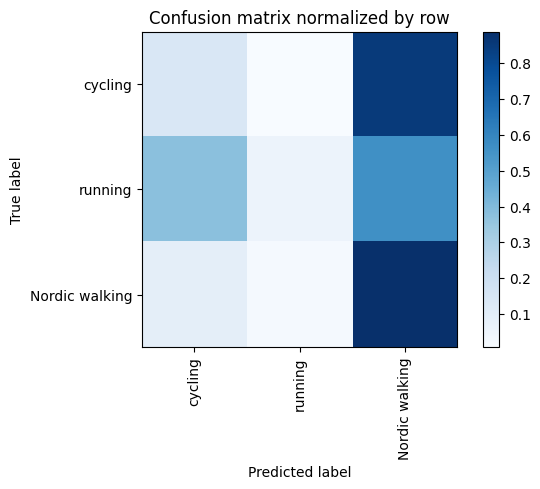

Overall accuracy: 0.436

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.463      0.886      0.608      0.419       1838|	 cycling: 0.091,	running: 0.022,	
       cycling       0.303      0.142      0.194      0.365       1601|	 Nordic walking: 0.849,	running: 0.009,	
       running       0.500      0.058      0.104      0.216        945|	 Nordic walking: 0.564,	cycling: 0.378,	

----------------------------------------------------------------------------------------------------
   avg / total       0.412      0.436      0.348        1.0       4384|	      

{'total_accuracy': 0.43613138686131386, 'precision': 0.4218138333723706, 'recall': 0.3623004987931062, 'f1': 0.30197582544414636}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']
Initiate IMU datasets ...
Initiate Skeleton dataset ... 
Initial Models ...
Start Models training ...


train: 100%|██████████| 567/567 [00:23<00:00, 24.19batch/s, loss=0.435, accuracy=0.844]


target feat mat torch.Size([15, 60, 36]) action feat mat (15, 128)


seen: 100%|██████████| 141/141 [00:05<00:00, 27.28batch/s, loss=0.69]


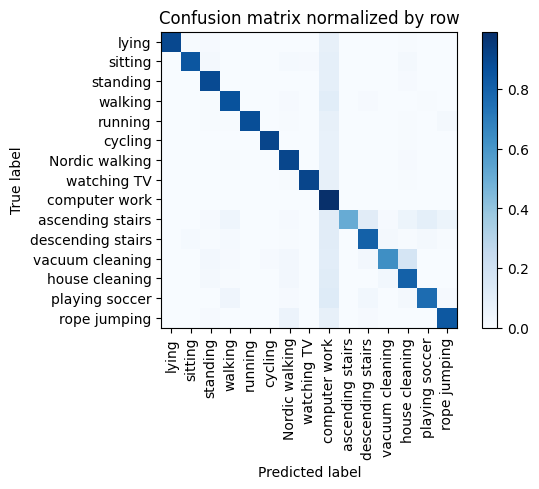

Training Epoch:  10%|█         | 1/10 [00:29<04:24, 29.44s/it]

Overall accuracy: 0.850



train: 100%|██████████| 567/567 [00:23<00:00, 24.20batch/s, loss=0.476, accuracy=0.812]


target feat mat torch.Size([15, 60, 36]) action feat mat (15, 128)


seen: 100%|██████████| 141/141 [00:05<00:00, 27.35batch/s, loss=0.595]


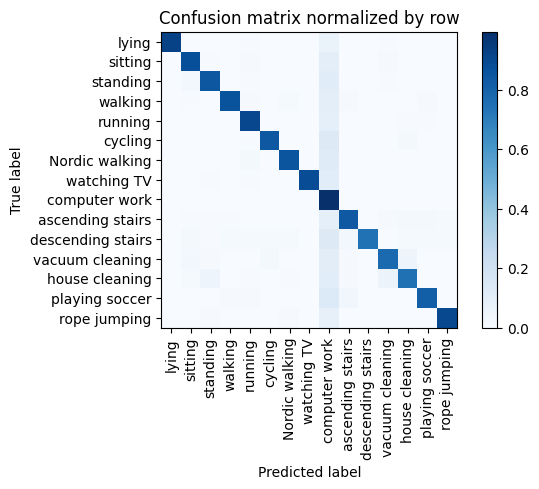

Training Epoch:  20%|██        | 2/10 [00:58<03:55, 29.47s/it]

Overall accuracy: 0.863



train: 100%|██████████| 567/567 [00:23<00:00, 24.45batch/s, loss=0.25, accuracy=0.906]


target feat mat torch.Size([15, 60, 36]) action feat mat (15, 128)


seen: 100%|██████████| 141/141 [00:05<00:00, 27.62batch/s, loss=0.48]


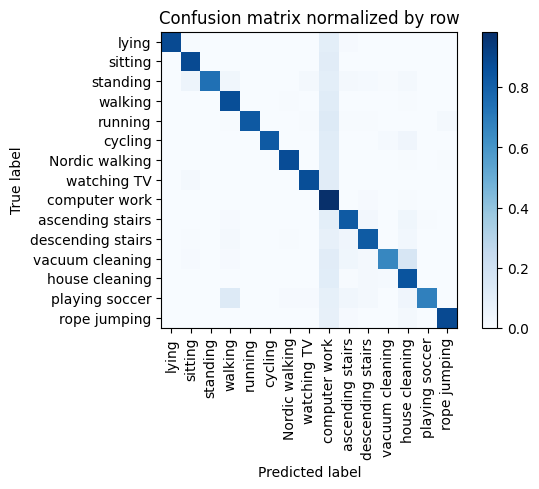

Training Epoch:  30%|███       | 3/10 [01:28<03:25, 29.40s/it]

Overall accuracy: 0.847



train: 100%|██████████| 567/567 [00:23<00:00, 23.95batch/s, loss=0.399, accuracy=0.844]


target feat mat torch.Size([15, 60, 36]) action feat mat (15, 128)


seen: 100%|██████████| 141/141 [00:05<00:00, 26.22batch/s, loss=0.426]


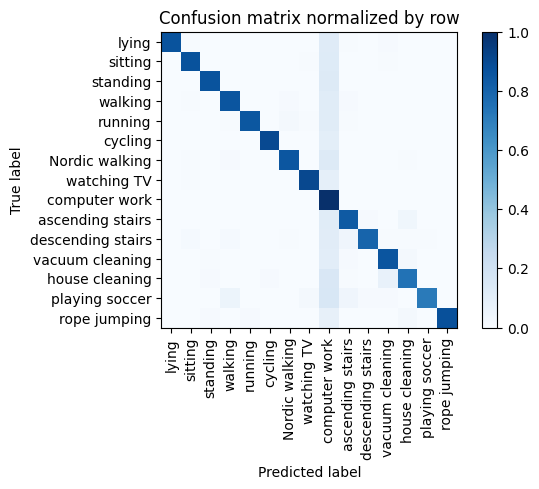

Training Epoch:  40%|████      | 4/10 [01:58<02:57, 29.59s/it]

Overall accuracy: 0.868



train: 100%|██████████| 567/567 [00:23<00:00, 24.46batch/s, loss=0.259, accuracy=0.875]


target feat mat torch.Size([15, 60, 36]) action feat mat (15, 128)


seen: 100%|██████████| 141/141 [00:05<00:00, 27.35batch/s, loss=0.345]


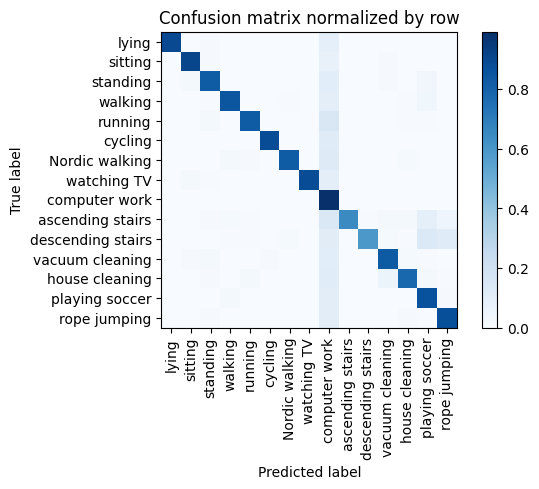

Training Epoch:  50%|█████     | 5/10 [02:27<02:27, 29.51s/it]

Overall accuracy: 0.850



train: 100%|██████████| 567/567 [00:23<00:00, 24.46batch/s, loss=0.437, accuracy=0.812]


target feat mat torch.Size([15, 60, 36]) action feat mat (15, 128)


seen: 100%|██████████| 141/141 [00:05<00:00, 27.47batch/s, loss=0.132]


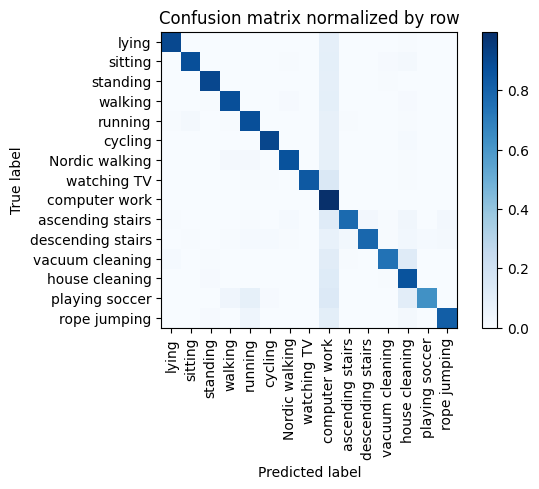

Training Epoch:  60%|██████    | 6/10 [02:56<01:57, 29.42s/it]

Overall accuracy: 0.871



train: 100%|██████████| 567/567 [00:23<00:00, 24.18batch/s, loss=0.236, accuracy=0.906]


target feat mat torch.Size([15, 60, 36]) action feat mat (15, 128)


seen: 100%|██████████| 141/141 [00:05<00:00, 26.41batch/s, loss=0.937]


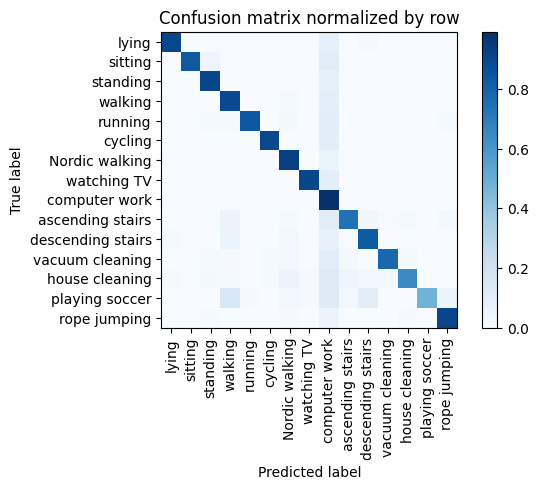

Training Epoch:  70%|███████   | 7/10 [03:26<01:28, 29.50s/it]

Overall accuracy: 0.858



train: 100%|██████████| 567/567 [00:23<00:00, 24.34batch/s, loss=0.253, accuracy=0.844]


target feat mat torch.Size([15, 60, 36]) action feat mat (15, 128)


seen: 100%|██████████| 141/141 [00:05<00:00, 27.47batch/s, loss=0.114]


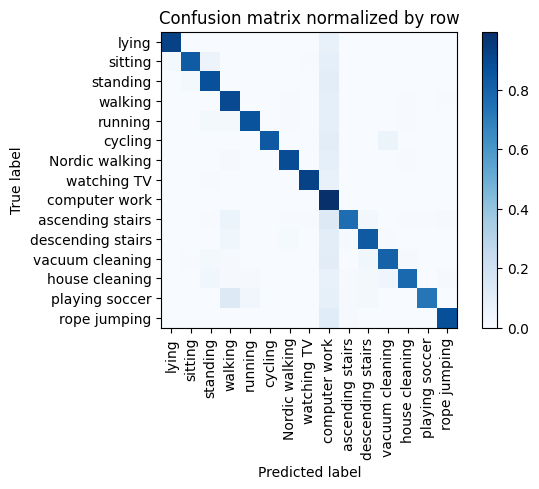

Training Epoch:  80%|████████  | 8/10 [03:55<00:58, 29.43s/it]

Overall accuracy: 0.869



train: 100%|██████████| 567/567 [00:23<00:00, 24.45batch/s, loss=0.147, accuracy=0.875]


target feat mat torch.Size([15, 60, 36]) action feat mat (15, 128)


seen: 100%|██████████| 141/141 [00:05<00:00, 27.42batch/s, loss=0.445]


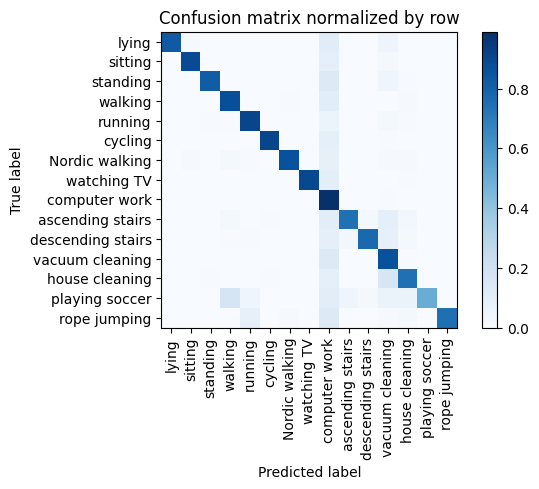

Training Epoch:  90%|█████████ | 9/10 [04:24<00:29, 29.36s/it]

Overall accuracy: 0.853



train: 100%|██████████| 567/567 [00:23<00:00, 24.31batch/s, loss=0.329, accuracy=0.844]


target feat mat torch.Size([15, 60, 36]) action feat mat (15, 128)


seen: 100%|██████████| 141/141 [00:05<00:00, 27.22batch/s, loss=-.0394]


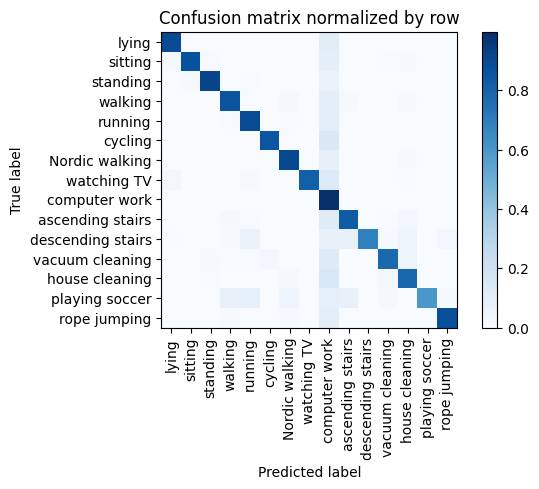

Overall accuracy: 0.863

target feat mat torch.Size([3, 60, 36]) action feat mat (3, 128)


unseen: 100%|██████████| 120/120 [00:04<00:00, 28.48batch/s, loss=29.1]


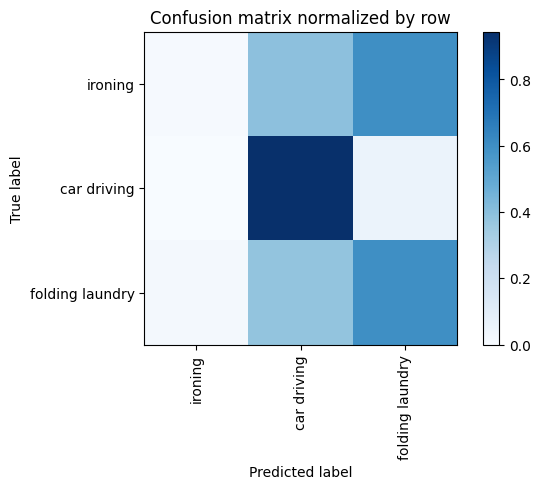

Overall accuracy: 0.288

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        ironing       0.462      0.008      0.015      0.607       2331|	 folding laundry: 0.598,	car driving: 0.394,	
folding laundry       0.291      0.600      0.392      0.254        975|	 car driving: 0.378,	ironing: 0.022,	
    car driving       0.281      0.944      0.434      0.139        534|	 folding laundry: 0.056,	ironing: 0.000,	

----------------------------------------------------------------------------------------------------
    avg / total       0.393      0.288      0.169        1.0       3840|	      

{'total_accuracy': 0.28828125, 'precision': 0.3446634242779147, 'recall': 0.5171807441470363, 'f1': 0.28023268650315686}
============== Overall Unseen Classes Performance ==============


total_accuracy    0.339223
precision         0.320844
recall            0.348135
f1                0.276090
dtype: float64

In [28]:
fold_metric_scores = []
for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')
    # separate seen/unseen and train/eval 
    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=5.21, window_overlap=4.21, resample_freq=20)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']

    train_n, seq_len, in_ft = data_dict['train']['X'].shape

    print("Initiate IMU datasets ...")
    # build IMU datasets
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=skeleton_mov, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt 
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=skeleton_mov, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=skeleton_mov, attribute_dict=action_dict, action_classes=unseen_classes, seq_len=100)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    print("Initiate Skeleton dataset ... ")
    # build Skeleton dataset 
    skel_dt = SkeletonDataset(skeleton_mov, skeleton_Ids, action_dict)
    skel_dl = DataLoader(skel_dt, batch_size=config['batch_size']//2, shuffle=True, pin_memory=True, drop_last=True)
    skel_n, skel_fts = skel_dt.getShape()
    
    print("Initial Models ...")
    # build IMU Encoder Model 
    imu_model = Model6a(in_ft=in_ft, d_model=config['d_model'], num_heads=config['num_heads'], ft_size=config['feat_size'], max_len=seq_len, n_classes=len(seen_classes))
    imu_model.to(device)

    # build AE Model 
    ae_model = LSTMAE(input_size=skel_fts, seq_len=skel_n, hidden_size=config['feat_size'], batch_size=config['batch_size'], ae_type='recursive', device=device)
    ae_model.to(device)
    
    # define IMU-Enc run parameters 
    imu_optim = Adam(imu_model.parameters(), lr=config['lr'])
    imu_loss_module = {'class': nn.CrossEntropyLoss(), 'feature': AttributeLoss()}
    best_acc = 0.0

    # define AE run parameters 
    ae_optim = Adam(ae_model.parameters(), lr=config['lr'])
    ae_loss_module = {'contrast': SupConLoss(), 'recons': nn.MSELoss()}

    print("Start Models training ...")
    # train 2 models E2E
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
        # train AE model 
        ae_train_metrics = ae_train_step1(ae_model, skel_dl, ae_optim, ae_loss_module, device, config['batch_size'], phase='train', loss_alpha=0.5)
        # train IMU-Enc model
        train_metrics = imu_train_step1(imu_model, ae_model, train_dl, imu_optim, imu_loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='train', loss_alpha=0.8)
        eval_metrics = eval_step1(imu_model, ae_model, eval_dl, imu_loss_module, device=device, class_names=[all_classes[i] for i in seen_classes],  target_feat_met=eval_dt.getClassAttrs(), phase='seen', print_report=False, loss_alpha=0.8, batch_size=config['batch_size'])
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['total_accuracy'] > best_acc:
            imu_best_model = deepcopy(imu_model.state_dict())

    # replace by best model 
    imu_model.load_state_dict(imu_best_model)

    # run evaluation on unseen classes
    test_metrics = eval_step1(imu_model, ae_model, test_dl, imu_loss_module, device=device, class_names=[all_classes[i] for i in unseen_classes],  target_feat_met=test_dt.getClassAttrs(), phase='unseen', loss_alpha=0.8, batch_size=config['batch_size'])
    fold_metric_scores.append(test_metrics)
    print(test_metrics)
    print("="*40)

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
seen_score_df.mean()
    